In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn

import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# Prueba hiperparámetros 3

In [13]:
emb_dim = 20
vocab_size = len(word_to_index)
# num_labels = 2
lstm_hidden_dim = 256

## ABOUT

In [14]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6737666770763929 	 Validation loss: 0.6680904606641349 	 
  1%|          | 574/57400 [00:03<05:19, 177.84it/s]
Epoch 2 	 Training loss: 0.659055072671445 	 Validation loss: 0.6601007742396856 	 
  2%|▏         | 1148/57400 [00:07<05:17, 177.38it/s]
Epoch 3 	 Training loss: 0.6517898641812261 	 Validation loss: 0.6525758757429608 	 
  3%|▎         | 1722/57400 [00:10<05:17, 175.27it/s]
Epoch 4 	 Training loss: 0.6434949879446927 	 Validation loss: 0.6437746741003909 	 
  4%|▍         | 2296/57400 [00:14<05:22, 171.03it/s]
Epoch 5 	 Training loss: 0.6346482069650178 	 Validation loss: 0.6384277939796448 	 
  5%|▌         | 2870/57400 [00:17<05:05, 178.39it/s]
Epoch 6 	 Training loss: 0.6270087225304248 	 Validation loss: 0.62832240836095 	 
  6%|▌         | 3444/57400 [00:21<05:16, 170.59it/s]
Epoch 7 	 Training loss: 0.617844689079278 	 Validation loss: 0.6259448619212135 	 
  7%|▋         | 4018/57400 [00:24<05:11, 171.54it/s]
Epoch 8 	 Training loss: 0.60978

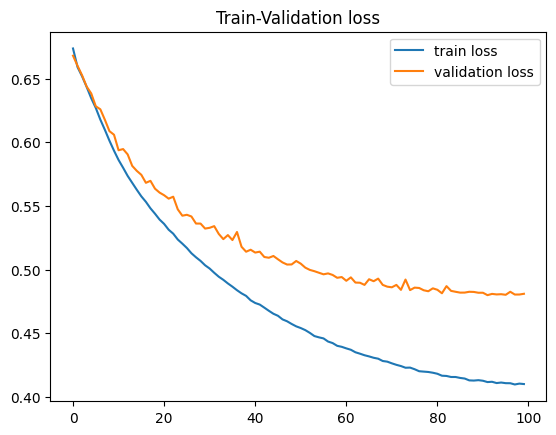

In [15]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v3_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6760204081632653, 'precision': 0.6760204081632653, 'f1': 0.6760204081632653, 'accuracy': 0.6760204081632653}
MALE {'recall': 0.7526041666666666, 'precision': 0.7526041666666666, 'f1': 0.7526041666666665, 'accuracy': 0.7526041666666666}
FEMALE {'recall': 0.6025, 'precision': 0.6025, 'f1': 0.6025, 'accuracy': 0.6025} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 0.5936739659367397, 'precision': 0.5936739659367397, 'f1': 0.5936739659367397, 'accuracy': 0.5936739659367397}
FEMALE {'recall': 0.43832020997375326, 'precision': 0.43832020997375326, 'f1': 0.43832020997375326, 'accuracy': 0.43832020997375326} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.60625814863103, 'precision': 0.60625814863103, 'f1': 0.60625814863103, 'accuracy': 0.60625814863103}
MALE {'recall': 0.62

In [17]:
# learning_rate = 5e-5
# optimizer = AdamW(model.parameters(), lr=learning_rate)

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6799141749064681 	 Validation loss: 0.6764972513004884 	 
  1%|          | 574/57400 [00:03<05:26, 174.07it/s]
Epoch 2 	 Training loss: 0.6672598817207257 	 Validation loss: 0.6641088077577494 	 
  2%|▏         | 1148/57400 [00:06<05:20, 175.42it/s]
Epoch 3 	 Training loss: 0.6539486950905896 	 Validation loss: 0.6469566478567609 	 
  3%|▎         | 1722/57400 [00:10<05:13, 177.40it/s]
Epoch 4 	 Training loss: 0.6412542829945528 	 Validation loss: 0.6389236581527581 	 
  4%|▍         | 2296/57400 [00:13<05:15, 174.66it/s]
Epoch 5 	 Training loss: 0.6300428692472105 	 Validation loss: 0.6250263008020692 	 
  5%|▌         | 2870/57400 [00:17<05:24, 168.01it/s]
Epoch 6 	 Training loss: 0.619013751529235 	 Validation loss: 0.6151978120965472 	 
  6%|▌         | 3444/57400 [00:20<05:11, 173.45it/s]
Epoch 7 	 Training loss: 0.6080507401389943 	 Validation loss: 0.6059083999213526 	 
  7%|▋         | 4018/57400 [00:24<05:08, 172.86it/s]
Epoch 8 	 Training loss: 0.59

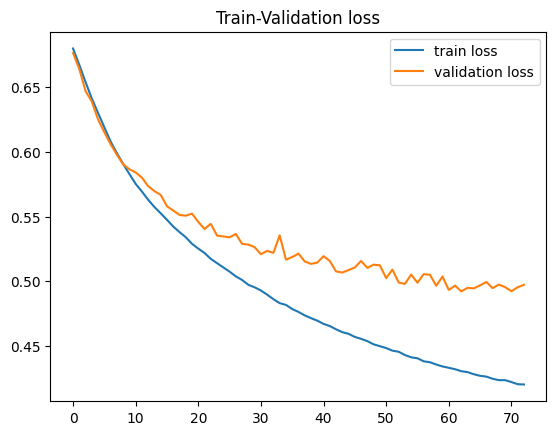

In [18]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v3_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5918367346938775, 'precision': 0.5918367346938775, 'f1': 0.5918367346938775, 'accuracy': 0.5918367346938775}
MALE {'recall': 0.96875, 'precision': 0.96875, 'f1': 0.96875, 'accuracy': 0.96875}
FEMALE {'recall': 0.23, 'precision': 0.23, 'f1': 0.23, 'accuracy': 0.23} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5328282828282829, 'precision': 0.5328282828282829, 'f1': 0.5328282828282829, 'accuracy': 0.5328282828282829}
MALE {'recall': 0.9148418491484185, 'precision': 0.9148418491484185, 'f1': 0.9148418491484185, 'accuracy': 0.9148418491484185}
FEMALE {'recall': 0.12073490813648294, 'precision': 0.12073490813648294, 'f1': 0.12073490813648294, 'accuracy': 0.12073490813648294} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5371577574967406, 'precision': 0.5371577574967406, 'f1': 0.5371577574967406, 'accuracy': 0.5371577574967406}
MALE {'recall': 0.9292929292929293, 'precision': 0.9292929292929

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6762843764409786 	 Validation loss: 0.6732336444369817 	 
  1%|          | 574/57400 [00:03<05:27, 173.40it/s]
Epoch 2 	 Training loss: 0.6611305981978307 	 Validation loss: 0.6621681684154576 	 
  2%|▏         | 1148/57400 [00:06<05:18, 176.82it/s]
Epoch 3 	 Training loss: 0.6540298907391285 	 Validation loss: 0.6563476334183903 	 
  3%|▎         | 1722/57400 [00:10<05:16, 176.08it/s]
Epoch 4 	 Training loss: 0.6477440165725734 	 Validation loss: 0.6497999358985384 	 
  4%|▍         | 2296/57400 [00:13<05:11, 177.16it/s]
Epoch 5 	 Training loss: 0.6404694471417404 	 Validation loss: 0.6438654418719016 	 
  5%|▌         | 2870/57400 [00:17<05:13, 173.96it/s]
Epoch 6 	 Training loss: 0.6321269288295652 	 Validation loss: 0.6370026044926401 	 
  6%|▌         | 3444/57400 [00:20<05:02, 178.54it/s]
Epoch 7 	 Training loss: 0.6230583392369207 	 Validation loss: 0.6287711202088049 	 
  7%|▋         | 4018/57400 [00:24<05:04, 175.32it/s]
Epoch 8 	 Training loss: 0.6

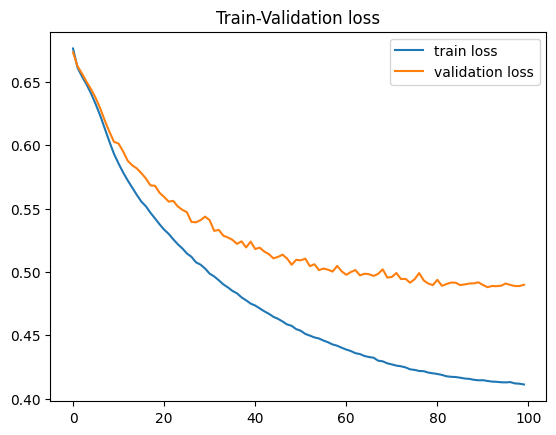

In [20]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v3_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6530612244897959, 'precision': 0.6530612244897959, 'f1': 0.6530612244897959, 'accuracy': 0.6530612244897959}
MALE {'recall': 0.9453125, 'precision': 0.9453125, 'f1': 0.9453125, 'accuracy': 0.9453125}
FEMALE {'recall': 0.3725, 'precision': 0.3725, 'f1': 0.3725, 'accuracy': 0.3725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5328282828282829, 'precision': 0.5328282828282829, 'f1': 0.5328282828282829, 'accuracy': 0.5328282828282829}
MALE {'recall': 0.8686131386861314, 'precision': 0.8686131386861314, 'f1': 0.8686131386861314, 'accuracy': 0.8686131386861314}
FEMALE {'recall': 0.17060367454068243, 'precision': 0.17060367454068243, 'f1': 0.17060367454068243, 'accuracy': 0.17060367454068243} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5488917861799217, 'precision': 0.5488917861799217, 'f1': 0.5488917861799217, 'accuracy': 0.5488917861799217}
MALE {'recall': 0.8964646464646465, 'precision':

In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6403061224489796, 'precision': 0.6403061224489796, 'f1': 0.6403061224489796, 'accuracy': 0.6403061224489796}
Métricas etiqueta male: {'recall': 0.8888888888888888, 'precision': 0.8888888888888888, 'f1': 0.8888888888888888, 'accuracy': 0.8888888888888888}
Métricas etiqueta female:  {'recall': 0.40166666666666667, 'precision': 0.40166666666666667, 'f1': 0.40166666666666667, 'accuracy': 0.40166666666666667}

 to
Resultado global: {'recall': 0.5281986531986532, 'precision': 0.5281986531986532, 'f1': 0.5281986531986532, 'accuracy': 0.5281986531986532}
Métricas etiqueta male: {'recall': 0.7923763179237632, 'precision': 0.7923763179237632, 'f1': 0.7923763179237632, 'accuracy': 0.7923763179237632}
Métricas etiqueta female:  {'recall': 0.2432195975503062, 'precision': 0.2432195975503062, 'f1': 0.2432195975503062, 'accuracy': 0.2432195975503062}

 as
Resultado global: {'recall': 0.5641025641025641, 'precision': 0.5641025641025641, 'f1':

## TO

In [23]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932630110077742 	 Validation loss: 0.6932700023812762 	 
  1%|          | 574/57400 [00:03<05:48, 163.27it/s]
Epoch 2 	 Training loss: 0.6931666843982524 	 Validation loss: 0.6927082902294094 	 
  2%|▏         | 1148/57400 [00:07<05:52, 159.55it/s]
Epoch 3 	 Training loss: 0.6931592518859624 	 Validation loss: 0.6941253492387675 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:11<05:51, 158.19it/s]
Epoch 4 	 Training loss: 0.6931184758708037 	 Validation loss: 0.692665915367967 	 
  4%|▍         | 2296/57400 [00:15<05:54, 155.35it/s]
Epoch 5 	 Training loss: 0.6931106225954116 	 Validation loss: 0.6933249043206037 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:19<05:39, 160.71it/s]
Epoch 6 	 Training loss: 0.6931899050802304 	 Validation loss: 0.6927970849861533 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:23<05:29, 163.72it/s]
Epoch 7 	 Training loss: 0.6930546232009184 	 Validation loss: 0.6929177742893413

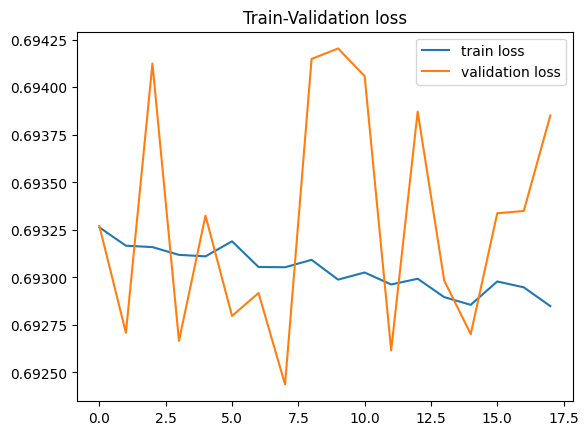

In [24]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v3_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
MALE {'recall': 0.018229166666666668, 'precision': 0.018229166666666668, 'f1': 0.018229166666666668, 'accuracy': 0.018229166666666668}
FEMALE {'recall': 0.9775, 'precision': 0.9775, 'f1': 0.9775, 'accuracy': 0.9775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4797979797979798, 'precision': 0.4797979797979798, 'f1': 0.4797979797979798, 'accuracy': 0.4797979797979798}
MALE {'recall': 0.014598540145985401, 'precision': 0.014598540145985401, 'f1': 0.014598540145985401, 'accuracy': 0.014598540145985401}
FEMALE {'recall': 0.9816272965879265, 'precision': 0.9816272965879265, 'f1': 0.9816272965879265, 'accuracy': 0.9816272965879265} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48239895697522817, 'precision': 0.48239895697522817, 'f1': 0.48239895697522817, 'accuracy': 0.482398956975228

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932196091691791 	 Validation loss: 0.6926296969591561 	 
  1%|          | 574/57400 [00:03<05:55, 159.70it/s]
Epoch 2 	 Training loss: 0.6932035206917686 	 Validation loss: 0.6934289043232545 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:07<05:59, 156.28it/s]
Epoch 3 	 Training loss: 0.6931652738242199 	 Validation loss: 0.692538871603497 	 
  3%|▎         | 1722/57400 [00:11<05:54, 157.27it/s]
Epoch 4 	 Training loss: 0.6931527660906522 	 Validation loss: 0.6922452702360639 	 
  4%|▍         | 2296/57400 [00:15<05:46, 159.03it/s]
Epoch 5 	 Training loss: 0.6930954484366374 	 Validation loss: 0.6940056237123781 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:19<05:46, 157.35it/s]
Epoch 6 	 Training loss: 0.6930627735649667 	 Validation loss: 0.6932041190438352 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:23<05:35, 160.84it/s]
Epoch 7 	 Training loss: 0.6930305535161952 	 Validation loss: 0.6928474054498187

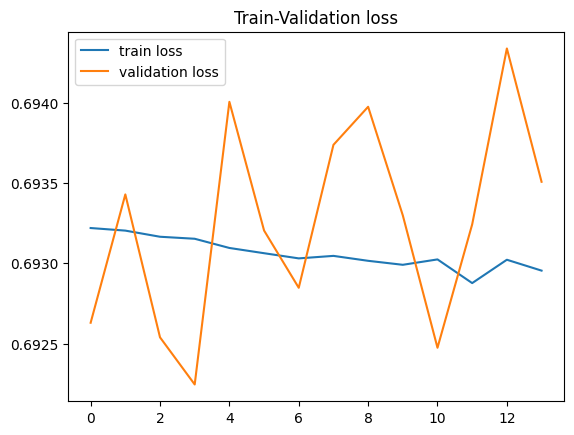

In [26]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v3_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5178571428571429, 'precision': 0.5178571428571429, 'f1': 0.5178571428571429, 'accuracy': 0.5178571428571429}
MALE {'recall': 0.15364583333333334, 'precision': 0.15364583333333334, 'f1': 0.15364583333333334, 'accuracy': 0.15364583333333334}
FEMALE {'recall': 0.8675, 'precision': 0.8675, 'f1': 0.8675, 'accuracy': 0.8675} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47853535353535354, 'precision': 0.47853535353535354, 'f1': 0.47853535353535354, 'accuracy': 0.47853535353535354}
MALE {'recall': 0.11192214111922141, 'precision': 0.11192214111922141, 'f1': 0.11192214111922141, 'accuracy': 0.11192214111922141}
FEMALE {'recall': 0.8740157480314961, 'precision': 0.8740157480314961, 'f1': 0.8740157480314961, 'accuracy': 0.8740157480314961} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5019556714471969, 'precision': 0.5019556714471969, 'f1': 0.5019556714471969, 'accuracy': 0.5019556714471969}
MALE

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933027185006424 	 Validation loss: 0.6934584631758222 	 
  1%|          | 574/57400 [00:03<05:51, 161.50it/s]
Epoch 2 	 Training loss: 0.6933002869634263 	 Validation loss: 0.6917067584344896 	 
  2%|▏         | 1148/57400 [00:07<05:56, 157.62it/s]
Epoch 3 	 Training loss: 0.6931884232713785 	 Validation loss: 0.6925819839461375 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:11<06:01, 154.19it/s]
Epoch 4 	 Training loss: 0.6931694849858301 	 Validation loss: 0.6935040809340396 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:15<05:44, 159.87it/s]
Epoch 5 	 Training loss: 0.6931629153909583 	 Validation loss: 0.693339527663538 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:19<05:42, 159.19it/s]
Epoch 6 	 Training loss: 0.6931186916520786 	 Validation loss: 0.6934947553327528 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:23<05:35, 160.96it/s]
Epoch 7 	 Training loss: 0.6931540288991629 	 Valida

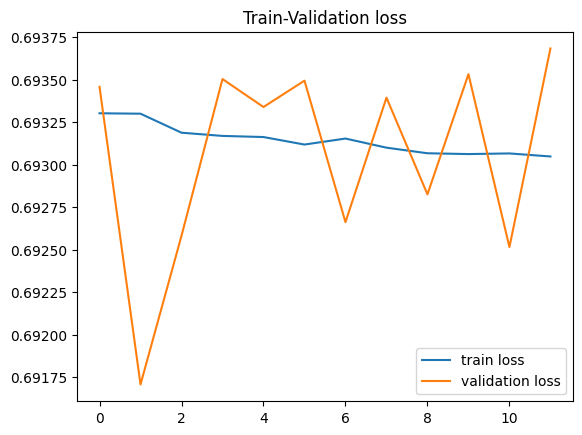

In [28]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v3_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
MALE {'recall': 0.0026041666666666665, 'precision': 0.0026041666666666665, 'f1': 0.0026041666666666665, 'accuracy': 0.0026041666666666665}
FEMALE {'recall': 0.9925, 'precision': 0.9925, 'f1': 0.9925, 'accuracy': 0.9925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4797979797979798, 'precision': 0.4797979797979798, 'f1': 0.4797979797979798, 'accuracy': 0.4797979797979798}
MALE {'recall': 0.004866180048661801, 'precision': 0.004866180048661801, 'f1': 0.004866180048661801, 'accuracy': 0.004866180048661801}
FEMALE {'recall': 0.9921259842519685, 'precision': 0.9921259842519685, 'f1': 0.9921259842519685, 'accuracy': 0.9921259842519685} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.48109517601043

In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5110544217687075, 'precision': 0.5110544217687075, 'f1': 0.5110544217687075, 'accuracy': 0.5110544217687075}
Métricas etiqueta male: {'recall': 0.058159722222222224, 'precision': 0.058159722222222224, 'f1': 0.058159722222222224, 'accuracy': 0.058159722222222224}
Métricas etiqueta female:  {'recall': 0.9458333333333334, 'precision': 0.9458333333333334, 'f1': 0.9458333333333334, 'accuracy': 0.9458333333333334}

 to
Resultado global: {'recall': 0.47937710437710435, 'precision': 0.47937710437710435, 'f1': 0.47937710437710435, 'accuracy': 0.47937710437710435}
Métricas etiqueta male: {'recall': 0.043795620437956206, 'precision': 0.043795620437956206, 'f1': 0.043795620437956206, 'accuracy': 0.043795620437956206}
Métricas etiqueta female:  {'recall': 0.9492563429571304, 'precision': 0.9492563429571304, 'f1': 0.9492563429571304, 'accuracy': 0.9492563429571304}

 as
Resultado global: {'recall': 0.4884832681442851, 'precision': 0.4884832

# AS

In [31]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932161470115807 	 Validation loss: 0.6923157249466848 	 
  1%|          | 574/57400 [00:03<06:02, 156.79it/s]
Epoch 2 	 Training loss: 0.6931349471055672 	 Validation loss: 0.6931561211408195 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:07<05:52, 159.75it/s]
Epoch 3 	 Training loss: 0.6930441577052405 	 Validation loss: 0.6928467326245066 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:11<05:45, 161.35it/s]
Epoch 4 	 Training loss: 0.6930493899338752 	 Validation loss: 0.6920576338040627 	 
  4%|▍         | 2296/57400 [00:15<05:40, 161.98it/s]
Epoch 5 	 Training loss: 0.6930252427838821 	 Validation loss: 0.6920655167708962 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:19<05:40, 160.17it/s]
Epoch 6 	 Training loss: 0.6929865073451598 	 Validation loss: 0.6929511357161958 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:23<05:44, 156.82it/s]
Epoch 7 	 Training loss: 0.6928918708492239 	 Valid

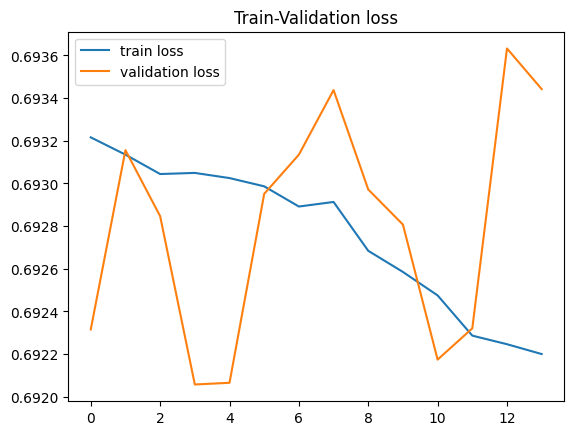

In [32]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v3_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5191326530612245, 'precision': 0.5191326530612245, 'f1': 0.5191326530612245, 'accuracy': 0.5191326530612245}
MALE {'recall': 0.06770833333333333, 'precision': 0.06770833333333333, 'f1': 0.06770833333333333, 'accuracy': 0.06770833333333333}
FEMALE {'recall': 0.9525, 'precision': 0.9525, 'f1': 0.9525, 'accuracy': 0.9525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47474747474747475, 'precision': 0.47474747474747475, 'f1': 0.47474747474747475, 'accuracy': 0.47474747474747475}
MALE {'recall': 0.0413625304136253, 'precision': 0.0413625304136253, 'f1': 0.0413625304136253, 'accuracy': 0.0413625304136253}
FEMALE {'recall': 0.9422572178477691, 'precision': 0.9422572178477691, 'f1': 0.9422572178477691, 'accuracy': 0.9422572178477691} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4876140808344198, 'precision': 0.4876140808344198, 'f1': 0.4876140808344198, 'accuracy': 0.4876140808344198}
MALE {'r

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932876077886242 	 Validation loss: 0.6919362716755625 	 
  1%|          | 574/57400 [00:03<05:56, 159.27it/s]
Epoch 2 	 Training loss: 0.6931100717197312 	 Validation loss: 0.6934025580600157 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:07<06:08, 152.55it/s]
Epoch 3 	 Training loss: 0.6930217168680052 	 Validation loss: 0.6926132864871267 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:11<05:49, 159.32it/s]
Epoch 4 	 Training loss: 0.6931318909656711 	 Validation loss: 0.6930174807370719 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:15<05:44, 159.99it/s]
Epoch 5 	 Training loss: 0.6930944569642535 	 Validation loss: 0.6921681185900155 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:19<05:43, 158.67it/s]
Epoch 6 	 Training loss: 0.6930047451203708 	 Validation loss: 0.6921797334137609 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:23<05:35, 160.87it/s]
Epoch 7 	 Training los

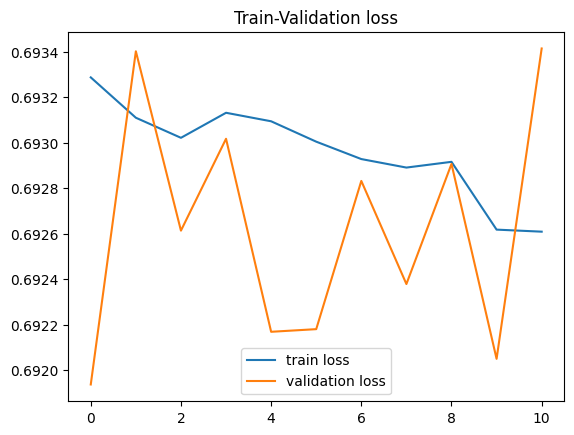

In [34]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v3_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932702427957116 	 Validation loss: 0.6929714538283267 	 
  1%|          | 574/57400 [00:03<05:50, 162.34it/s]
Epoch 2 	 Training loss: 0.6931586269717599 	 Validation loss: 0.6933780544895237 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:07<05:59, 156.50it/s]
Epoch 3 	 Training loss: 0.6931491654093672 	 Validation loss: 0.6926355462963298 	 
  3%|▎         | 1722/57400 [00:11<05:42, 162.67it/s]
Epoch 4 	 Training loss: 0.6930654601352971 	 Validation loss: 0.6926789152420173 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:15<05:47, 158.41it/s]
Epoch 5 	 Training loss: 0.6930403689681861 	 Validation loss: 0.6924099012956781 	 
  5%|▌         | 2870/57400 [00:19<05:46, 157.30it/s]
Epoch 6 	 Training loss: 0.6929500796653668 	 Validation loss: 0.6926036012374749 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:23<05:41, 157.83it/s]
Epoch 7 	 Training loss: 0.6928474665311155 	 Validation loss: 0.692701551873805

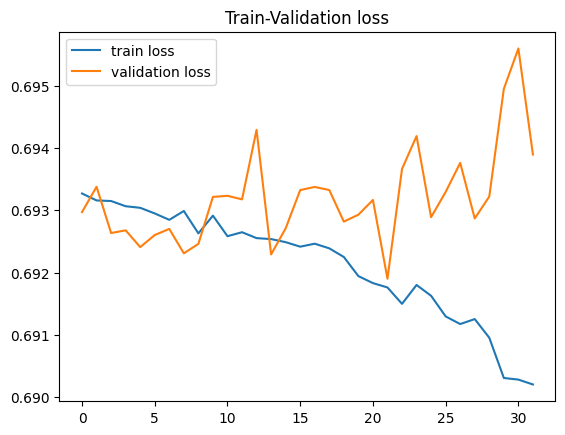

In [36]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v3_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49362244897959184, 'precision': 0.49362244897959184, 'f1': 0.49362244897959184, 'accuracy': 0.49362244897959184}
MALE {'recall': 0.40625, 'precision': 0.40625, 'f1': 0.40625, 'accuracy': 0.40625}
FEMALE {'recall': 0.5775, 'precision': 0.5775, 'f1': 0.5775, 'accuracy': 0.5775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5290404040404041, 'precision': 0.5290404040404041, 'f1': 0.5290404040404041, 'accuracy': 0.5290404040404041}
MALE {'recall': 0.43309002433090027, 'precision': 0.43309002433090027, 'f1': 0.43309002433090027, 'accuracy': 0.43309002433090027}
FEMALE {'recall': 0.6325459317585301, 'precision': 0.6325459317585301, 'f1': 0.6325459317585301, 'accuracy': 0.6325459317585301} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5071707953063885, 'precision': 0.5071707953063885, 'f1': 0.5071707953063885, 'accuracy': 0.5071707953063885}
MALE {'recall': 0.3484848484848485, 'precision': 0.3

In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
Métricas etiqueta male: {'recall': 0.1579861111111111, 'precision': 0.1579861111111111, 'f1': 0.1579861111111111, 'accuracy': 0.1579861111111111}
Métricas etiqueta female:  {'recall': 0.8433333333333334, 'precision': 0.8433333333333334, 'f1': 0.8433333333333334, 'accuracy': 0.8433333333333334}

 to
Resultado global: {'recall': 0.494949494949495, 'precision': 0.494949494949495, 'f1': 0.494949494949495, 'accuracy': 0.494949494949495}
Métricas etiqueta male: {'recall': 0.15815085158150852, 'precision': 0.15815085158150852, 'f1': 0.15815085158150852, 'accuracy': 0.15815085158150852}
Métricas etiqueta female:  {'recall': 0.8582677165354331, 'precision': 0.8582677165354331, 'f1': 0.8582677165354331, 'accuracy': 0.8582677165354331}

 as
Resultado global: {'recall': 0.49282920469361147, 'precision': 0.49282920469361147, 'f1': 0

# Pruebas hiperparámetros 2

In [39]:
emb_dim = 40
vocab_size = len(word_to_index)
# num_labels = 2
lstm_hidden_dim = 128

## ABOUT

In [40]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6801343502067938 	 Validation loss: 0.6805711055206041 	 
  1%|          | 574/57400 [00:02<04:22, 216.69it/s]
Epoch 2 	 Training loss: 0.6648125789722084 	 Validation loss: 0.6555347513344328 	 
  2%|▏         | 1148/57400 [00:05<04:17, 218.33it/s]
Epoch 3 	 Training loss: 0.6436049376422935 	 Validation loss: 0.6376385941343793 	 
  3%|▎         | 1722/57400 [00:08<04:13, 219.85it/s]
Epoch 4 	 Training loss: 0.6283719955005712 	 Validation loss: 0.6230367240259203 	 
  4%|▍         | 2296/57400 [00:11<04:15, 215.72it/s]
Epoch 5 	 Training loss: 0.6144619326558263 	 Validation loss: 0.612612662679058 	 
  5%|▌         | 2870/57400 [00:14<04:10, 217.77it/s]
Epoch 6 	 Training loss: 0.6012792844805568 	 Validation loss: 0.6074499326237177 	 
  6%|▌         | 3444/57400 [00:17<04:05, 220.04it/s]
Epoch 7 	 Training loss: 0.5885865827470707 	 Validation loss: 0.5879365685632674 	 
  7%|▋         | 4018/57400 [00:19<04:05, 217.69it/s]
Epoch 8 	 Training loss: 0.57

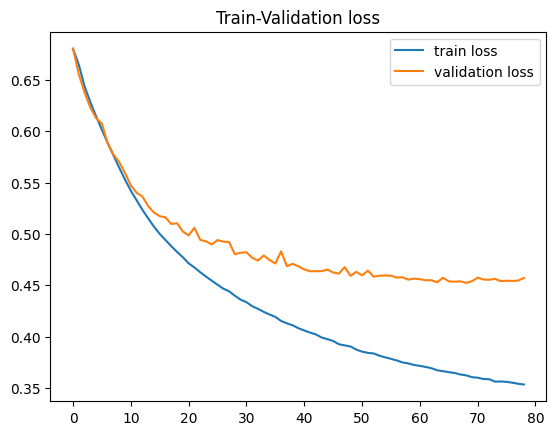

In [41]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v4_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [42]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6811224489795918, 'precision': 0.6811224489795918, 'f1': 0.6811224489795918, 'accuracy': 0.6811224489795918}
MALE {'recall': 0.6927083333333334, 'precision': 0.6927083333333334, 'f1': 0.6927083333333334, 'accuracy': 0.6927083333333334}
FEMALE {'recall': 0.67, 'precision': 0.67, 'f1': 0.67, 'accuracy': 0.67} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5328282828282829, 'precision': 0.5328282828282829, 'f1': 0.5328282828282829, 'accuracy': 0.5328282828282829}
MALE {'recall': 0.5036496350364964, 'precision': 0.5036496350364964, 'f1': 0.5036496350364964, 'accuracy': 0.5036496350364964}
FEMALE {'recall': 0.5643044619422573, 'precision': 0.5643044619422573, 'f1': 0.5643044619422573, 'accuracy': 0.5643044619422573} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6036505867014341, 'precision': 0.6036505867014341, 'f1': 0.6036505867014341, 'accuracy': 0.6036505867014341}
MALE {'recall': 0.606060

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6779407740470009 	 Validation loss: 0.6678016832319357 	 
  1%|          | 574/57400 [00:02<04:30, 209.82it/s]
Epoch 2 	 Training loss: 0.6540754926536972 	 Validation loss: 0.6534686846248174 	 
  2%|▏         | 1148/57400 [00:05<04:17, 218.50it/s]
Epoch 3 	 Training loss: 0.6404139867850712 	 Validation loss: 0.6386766059923981 	 
  3%|▎         | 1722/57400 [00:08<04:23, 211.06it/s]
Epoch 4 	 Training loss: 0.6292406291496463 	 Validation loss: 0.6267623325525704 	 
  4%|▍         | 2296/57400 [00:11<04:13, 216.97it/s]
Epoch 5 	 Training loss: 0.6175046032521783 	 Validation loss: 0.6166237804849269 	 
  5%|▌         | 2870/57400 [00:14<04:09, 218.50it/s]
Epoch 6 	 Training loss: 0.6054094587468934 	 Validation loss: 0.6068460517010447 	 
  6%|▌         | 3444/57400 [00:17<04:05, 219.84it/s]
Epoch 7 	 Training loss: 0.5927133283444813 	 Validation loss: 0.5985670200848984 	 
  7%|▋         | 4018/57400 [00:19<04:02, 220.43it/s]
Epoch 8 	 Training loss: 0.5

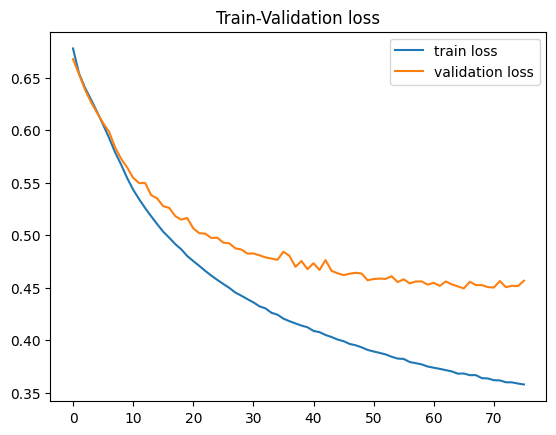

In [43]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v4_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [44]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6747448979591837, 'precision': 0.6747448979591837, 'f1': 0.6747448979591837, 'accuracy': 0.6747448979591837}
MALE {'recall': 0.9166666666666666, 'precision': 0.9166666666666666, 'f1': 0.9166666666666666, 'accuracy': 0.9166666666666666}
FEMALE {'recall': 0.4425, 'precision': 0.4425, 'f1': 0.4425, 'accuracy': 0.4425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5492424242424242, 'precision': 0.5492424242424242, 'f1': 0.5492424242424242, 'accuracy': 0.5492424242424242}
MALE {'recall': 0.805352798053528, 'precision': 0.805352798053528, 'f1': 0.805352798053528, 'accuracy': 0.805352798053528}
FEMALE {'recall': 0.27296587926509186, 'precision': 0.27296587926509186, 'f1': 0.27296587926509186, 'accuracy': 0.27296587926509186} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5788787483702738, 'precision': 0.5788787483702738, 'f1': 0.5788787483702738, 'accuracy': 0.5788787483702738}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6789886970137885 	 Validation loss: 0.6755511568764508 	 
  1%|          | 574/57400 [00:02<04:20, 218.31it/s]
Epoch 2 	 Training loss: 0.65485973837899 	 Validation loss: 0.6466871651552492 	 
  2%|▏         | 1148/57400 [00:05<04:19, 216.74it/s]
Epoch 3 	 Training loss: 0.6369198900274283 	 Validation loss: 0.6330306055182118 	 
  3%|▎         | 1722/57400 [00:08<04:12, 220.54it/s]
Epoch 4 	 Training loss: 0.6219111703829483 	 Validation loss: 0.6224976050651679 	 
  4%|▍         | 2296/57400 [00:11<04:13, 217.34it/s]
Epoch 5 	 Training loss: 0.6071096697127778 	 Validation loss: 0.6048336483664432 	 
  5%|▌         | 2870/57400 [00:14<04:14, 214.25it/s]
Epoch 6 	 Training loss: 0.5927057836840792 	 Validation loss: 0.5940557890019175 	 
  6%|▌         | 3444/57400 [00:17<04:13, 212.85it/s]
Epoch 7 	 Training loss: 0.5799017044413796 	 Validation loss: 0.581496294272148 	 
  7%|▋         | 4018/57400 [00:19<04:12, 211.07it/s]
Epoch 8 	 Training loss: 0.5678

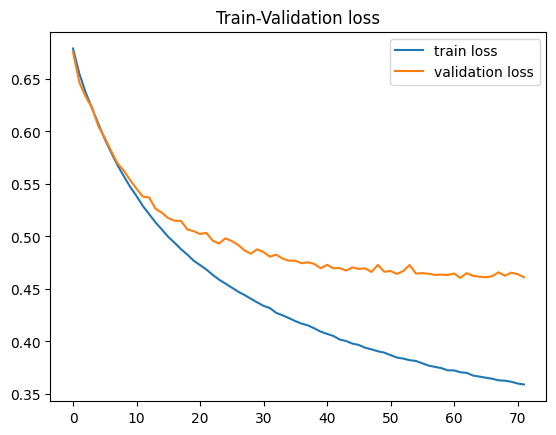

In [45]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v4_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [46]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6900510204081632, 'precision': 0.6900510204081632, 'f1': 0.6900510204081632, 'accuracy': 0.6900510204081632}
MALE {'recall': 0.6640625, 'precision': 0.6640625, 'f1': 0.6640625, 'accuracy': 0.6640625}
FEMALE {'recall': 0.715, 'precision': 0.715, 'f1': 0.715, 'accuracy': 0.715} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5075757575757576, 'precision': 0.5075757575757576, 'f1': 0.5075757575757576, 'accuracy': 0.5075757575757576}
MALE {'recall': 0.48418491484184917, 'precision': 0.48418491484184917, 'f1': 0.48418491484184917, 'accuracy': 0.48418491484184917}
FEMALE {'recall': 0.5328083989501312, 'precision': 0.5328083989501312, 'f1': 0.5328083989501312, 'accuracy': 0.5328083989501312} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5697522816166884, 'precision': 0.5697522816166884, 'f1': 0.5697522816166884, 'accuracy': 0.5697522816166884}
MALE {'recall': 0.5656565656565656, 'precision': 0.5

In [47]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6819727891156463, 'precision': 0.6819727891156463, 'f1': 0.6819727891156463, 'accuracy': 0.6819727891156463}
Métricas etiqueta male: {'recall': 0.7578125, 'precision': 0.7578125, 'f1': 0.7578125, 'accuracy': 0.7578125}
Métricas etiqueta female:  {'recall': 0.6091666666666666, 'precision': 0.6091666666666666, 'f1': 0.6091666666666666, 'accuracy': 0.6091666666666666}

 to
Resultado global: {'recall': 0.5298821548821548, 'precision': 0.5298821548821548, 'f1': 0.5298821548821548, 'accuracy': 0.5298821548821548}
Métricas etiqueta male: {'recall': 0.5977291159772912, 'precision': 0.5977291159772912, 'f1': 0.5977291159772912, 'accuracy': 0.5977291159772912}
Métricas etiqueta female:  {'recall': 0.4566929133858268, 'precision': 0.4566929133858268, 'f1': 0.4566929133858268, 'accuracy': 0.4566929133858268}

 as
Resultado global: {'recall': 0.5840938722294654, 'precision': 0.5840938722294654, 'f1': 0.5840938722294654, 'accuracy': 0.58409

## TO

In [48]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693285003252561 	 Validation loss: 0.6932302410319701 	 
  1%|          | 574/57400 [00:03<05:11, 182.61it/s]
Epoch 2 	 Training loss: 0.6932077178348648 	 Validation loss: 0.6944678425788879 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:21, 175.20it/s]
Epoch 3 	 Training loss: 0.6931125472854655 	 Validation loss: 0.693063618773121 	 
  3%|▎         | 1722/57400 [00:10<05:56, 156.20it/s]
Epoch 4 	 Training loss: 0.6931205547645117 	 Validation loss: 0.6924183388887826 	 
  4%|▍         | 2296/57400 [00:13<05:07, 179.22it/s]
Epoch 5 	 Training loss: 0.693104502527556 	 Validation loss: 0.6936009546457711 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:17<05:11, 175.25it/s]
Epoch 6 	 Training loss: 0.6930560168488931 	 Validation loss: 0.692726465605073 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:20<04:59, 180.29it/s]
Epoch 7 	 Training loss: 0.6930982548393023 	 Validation loss: 0.6938545865527654 	 

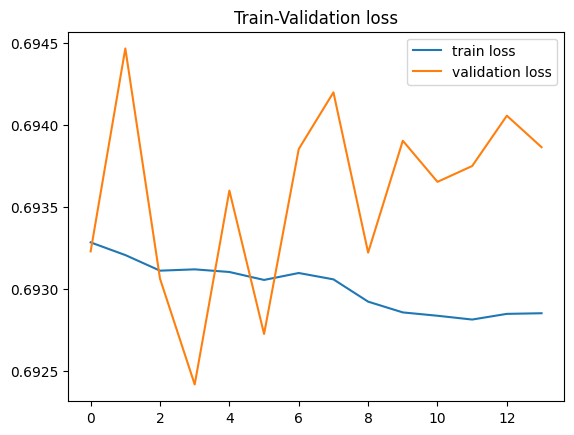

In [49]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v4_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [51]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load('m1_rrnn_simple_to_v4_1'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5153061224489796, 'precision': 0.5153061224489796, 'f1': 0.5153061224489796, 'accuracy': 0.5153061224489796}
MALE {'recall': 0.0390625, 'precision': 0.0390625, 'f1': 0.0390625, 'accuracy': 0.0390625}
FEMALE {'recall': 0.9725, 'precision': 0.9725, 'f1': 0.9725, 'accuracy': 0.9725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4797979797979798, 'precision': 0.4797979797979798, 'f1': 0.4797979797979798, 'accuracy': 0.4797979797979798}
MALE {'recall': 0.021897810218978103, 'precision': 0.021897810218978103, 'f1': 0.021897810218978103, 'accuracy': 0.021897810218978103}
FEMALE {'recall': 0.973753280839895, 'precision': 0.973753280839895, 'f1': 0.973753280839895, 'accuracy': 0.973753280839895} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4758800521512386, 'precision': 0.4758800521512386, 'f1': 0.4758800521512386, 'accuracy': 0.4758800521512386}
MALE {'recall': 0.007575757575757576, 'precision

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.69329236432235 	 Validation loss: 0.6934787843186977 	 
  1%|          | 574/57400 [00:03<05:19, 178.09it/s]
Epoch 2 	 Training loss: 0.6932371957584541 	 Validation loss: 0.6923900246620178 	 
  2%|▏         | 1148/57400 [00:07<05:24, 173.57it/s]
Epoch 3 	 Training loss: 0.693185630679546 	 Validation loss: 0.6923909288341716 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:16, 176.17it/s]
Epoch 4 	 Training loss: 0.6930943304861049 	 Validation loss: 0.6928277147018304 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:14<05:02, 181.92it/s]
Epoch 5 	 Training loss: 0.6930642165373426 	 Validation loss: 0.6930242079799458 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:17<05:00, 181.71it/s]
Epoch 6 	 Training loss: 0.6929957242585225 	 Validation loss: 0.6923316909094989 	 
  6%|▌         | 3444/57400 [00:21<04:55, 182.47it/s]
Epoch 7 	 Training loss: 0.6930224862248224 	 Validation loss: 0.6937224218400858 	

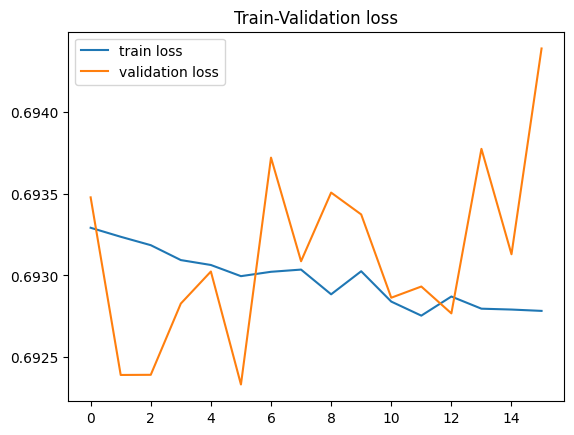

In [52]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v4_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [53]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5165816326530612, 'precision': 0.5165816326530612, 'f1': 0.5165816326530612, 'accuracy': 0.5165816326530612}
MALE {'recall': 0.026041666666666668, 'precision': 0.026041666666666668, 'f1': 0.026041666666666668, 'accuracy': 0.026041666666666668}
FEMALE {'recall': 0.9875, 'precision': 0.9875, 'f1': 0.9875, 'accuracy': 0.9875} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47474747474747475, 'precision': 0.47474747474747475, 'f1': 0.47474747474747475, 'accuracy': 0.47474747474747475}
MALE {'recall': 0.0267639902676399, 'precision': 0.0267639902676399, 'f1': 0.0267639902676399, 'accuracy': 0.0267639902676399}
FEMALE {'recall': 0.958005249343832, 'precision': 0.958005249343832, 'f1': 0.958005249343832, 'accuracy': 0.958005249343832} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'r

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933129079873553 	 Validation loss: 0.6929835990323858 	 
  1%|          | 574/57400 [00:03<05:10, 182.89it/s]
Epoch 2 	 Training loss: 0.6931779471839347 	 Validation loss: 0.6936742845228163 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:21, 175.19it/s]
Epoch 3 	 Training loss: 0.6931645156822138 	 Validation loss: 0.6930577876204151 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:04, 183.06it/s]
Epoch 4 	 Training loss: 0.6931029316232595 	 Validation loss: 0.6927221154762526 	 
  4%|▍         | 2296/57400 [00:13<05:05, 180.10it/s]
Epoch 5 	 Training loss: 0.693068264564986 	 Validation loss: 0.6926280856132507 	 
  5%|▌         | 2870/57400 [00:17<05:07, 177.18it/s]
Epoch 6 	 Training loss: 0.6931454222584436 	 Validation loss: 0.6935841279514765 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:20<04:53, 183.93it/s]
Epoch 7 	 Training loss: 0.693123054317481 	 Validation loss: 0.6936702263557305 

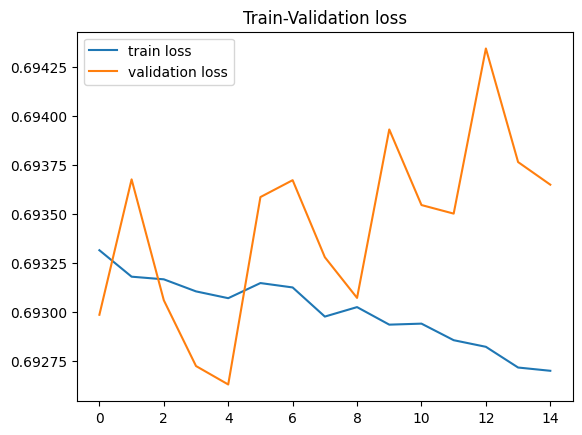

In [54]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v4_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [55]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5153061224489796, 'precision': 0.5153061224489796, 'f1': 0.5153061224489796, 'accuracy': 0.5153061224489796}
MALE {'recall': 0.036458333333333336, 'precision': 0.036458333333333336, 'f1': 0.036458333333333336, 'accuracy': 0.036458333333333336}
FEMALE {'recall': 0.975, 'precision': 0.975, 'f1': 0.975, 'accuracy': 0.975} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47853535353535354, 'precision': 0.47853535353535354, 'f1': 0.47853535353535354, 'accuracy': 0.47853535353535354}
MALE {'recall': 0.014598540145985401, 'precision': 0.014598540145985401, 'f1': 0.014598540145985401, 'accuracy': 0.014598540145985401}
FEMALE {'recall': 0.979002624671916, 'precision': 0.979002624671916, 'f1': 0.979002624671916, 'accuracy': 0.979002624671916} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4876140808344198, 'precision': 0.4876140808344198, 'f1': 0.4876140808344198, 'accuracy': 0.4876140808344198}
MALE

In [56]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5157312925170068, 'precision': 0.5157312925170068, 'f1': 0.5157312925170068, 'accuracy': 0.5157312925170068}
Métricas etiqueta male: {'recall': 0.03385416666666667, 'precision': 0.03385416666666667, 'f1': 0.03385416666666667, 'accuracy': 0.03385416666666667}
Métricas etiqueta female:  {'recall': 0.9783333333333334, 'precision': 0.9783333333333334, 'f1': 0.9783333333333334, 'accuracy': 0.9783333333333334}

 to
Resultado global: {'recall': 0.47769360269360267, 'precision': 0.47769360269360267, 'f1': 0.47769360269360267, 'accuracy': 0.47769360269360267}
Métricas etiqueta male: {'recall': 0.021086780210867802, 'precision': 0.021086780210867802, 'f1': 0.021086780210867802, 'accuracy': 0.021086780210867802}
Métricas etiqueta female:  {'recall': 0.9702537182852143, 'precision': 0.9702537182852143, 'f1': 0.9702537182852143, 'accuracy': 0.9702537182852143}

 as
Resultado global: {'recall': 0.4815297696653629, 'precision': 0.48152976966

## AS

In [57]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932504005756113 	 Validation loss: 0.6927110552787781 	 
  1%|          | 574/57400 [00:03<05:16, 179.57it/s]
Epoch 2 	 Training loss: 0.6931090869970022 	 Validation loss: 0.6932096299478563 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:21, 175.16it/s]
Epoch 3 	 Training loss: 0.6931229878593405 	 Validation loss: 0.692756479069338 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:09, 180.15it/s]
Epoch 4 	 Training loss: 0.6929965935102324 	 Validation loss: 0.6927855843204563 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:13<05:04, 181.06it/s]
Epoch 5 	 Training loss: 0.6929294182448437 	 Validation loss: 0.6920345233658612 	 
  5%|▌         | 2870/57400 [00:17<05:04, 179.36it/s]
Epoch 6 	 Training loss: 0.6930099619805605 	 Validation loss: 0.6928317516537036 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:20<05:13, 172.10it/s]
Epoch 7 	 Training loss: 0.6928166027476148 	 Valida

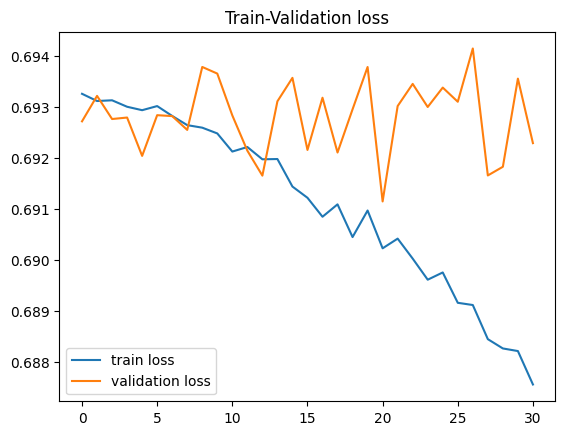

In [58]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v4_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [59]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.47066326530612246, 'precision': 0.47066326530612246, 'f1': 0.47066326530612246, 'accuracy': 0.47066326530612246}
MALE {'recall': 0.7864583333333334, 'precision': 0.7864583333333334, 'f1': 0.7864583333333334, 'accuracy': 0.7864583333333334}
FEMALE {'recall': 0.1675, 'precision': 0.1675, 'f1': 0.1675, 'accuracy': 0.1675} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}
MALE {'recall': 0.8759124087591241, 'precision': 0.8759124087591241, 'f1': 0.8759124087591241, 'accuracy': 0.8759124087591241}
FEMALE {'recall': 0.13648293963254593, 'precision': 0.13648293963254593, 'f1': 0.13648293963254593, 'accuracy': 0.13648293963254593} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5319426336375489, 'precision': 0.5319426336375489, 'f1': 0.5319426336375489, 'accuracy': 0.5319426336375489}
MALE {'r

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932330491858493 	 Validation loss: 0.6928887367248535 	 
  1%|          | 574/57400 [00:03<05:16, 179.55it/s]
Epoch 2 	 Training loss: 0.6931566192090304 	 Validation loss: 0.6938881086090863 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:20, 175.53it/s]
Epoch 3 	 Training loss: 0.6930179530527534 	 Validation loss: 0.6937067468287581 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:11, 179.02it/s]
Epoch 4 	 Training loss: 0.6930153906760731 	 Validation loss: 0.6929667076822055 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:13<05:06, 179.90it/s]
Epoch 5 	 Training loss: 0.6929599742440812 	 Validation loss: 0.6925637024944111 	 
  5%|▌         | 2870/57400 [00:17<05:07, 177.27it/s]
Epoch 6 	 Training loss: 0.6929863312310873 	 Validation loss: 0.6934644903166819 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:20<05:04, 177.44it/s]
Epoch 7 	 Training loss: 0.6926755049502809 	 Valid

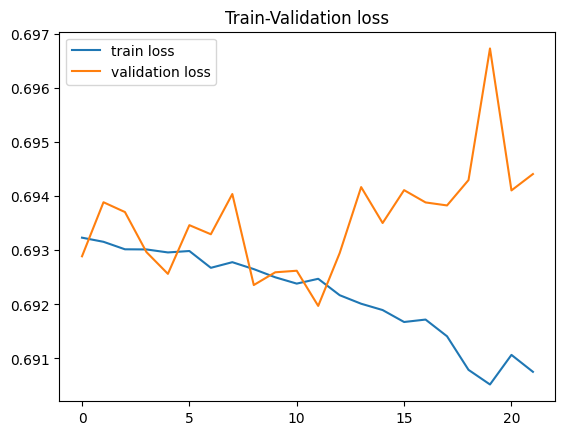

In [60]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v4_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [61]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5127551020408163, 'precision': 0.5127551020408163, 'f1': 0.5127551020408163, 'accuracy': 0.5127551020408163}
MALE {'recall': 0.16927083333333334, 'precision': 0.16927083333333334, 'f1': 0.16927083333333334, 'accuracy': 0.16927083333333334}
FEMALE {'recall': 0.8425, 'precision': 0.8425, 'f1': 0.8425, 'accuracy': 0.8425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48358585858585856, 'precision': 0.48358585858585856, 'f1': 0.48358585858585856, 'accuracy': 0.48358585858585856}
MALE {'recall': 0.13138686131386862, 'precision': 0.13138686131386862, 'f1': 0.13138686131386862, 'accuracy': 0.13138686131386862}
FEMALE {'recall': 0.863517060367454, 'precision': 0.863517060367454, 'f1': 0.863517060367454, 'accuracy': 0.863517060367454} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49022164276401564, 'precision': 0.49022164276401564, 'f1': 0.49022164276401564, 'accuracy': 0.49022164276401564}
MALE

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932335797087241 	 Validation loss: 0.6923979631925034 	 
  1%|          | 574/57400 [00:03<05:15, 180.13it/s]
Epoch 2 	 Training loss: 0.693153607305334 	 Validation loss: 0.6935296442549107 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:07<05:23, 173.95it/s]
Epoch 3 	 Training loss: 0.6931441656803835 	 Validation loss: 0.693539387088711 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:09, 180.12it/s]
Epoch 4 	 Training loss: 0.6929729979628054 	 Validation loss: 0.6927604341911058 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:13<05:11, 176.85it/s]
Epoch 5 	 Training loss: 0.6929117261532707 	 Validation loss: 0.6928380273156247 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:17<05:03, 179.81it/s]
Epoch 6 	 Training loss: 0.6928318863546391 	 Validation loss: 0.6927257392366054 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:20<05:03, 177.53it/s]
Epoch 7 	 Training loss:

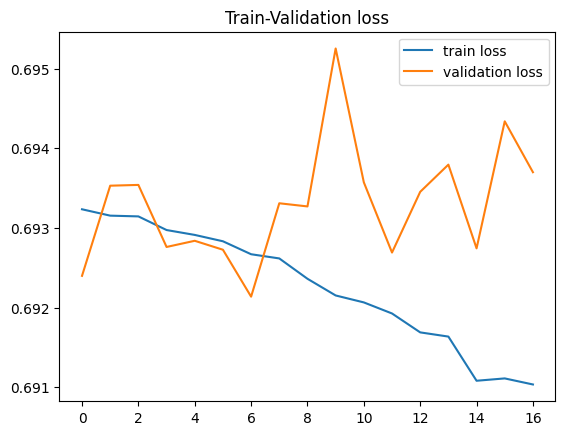

In [62]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v4_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [63]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.46683673469387754, 'precision': 0.46683673469387754, 'f1': 0.46683673469387754, 'accuracy': 0.46683673469387754}
MALE {'recall': 0.203125, 'precision': 0.203125, 'f1': 0.203125, 'accuracy': 0.203125}
FEMALE {'recall': 0.72, 'precision': 0.72, 'f1': 0.72, 'accuracy': 0.72} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5075757575757576, 'precision': 0.5075757575757576, 'f1': 0.5075757575757576, 'accuracy': 0.5075757575757576}
MALE {'recall': 0.23114355231143552, 'precision': 0.23114355231143552, 'f1': 0.23114355231143552, 'accuracy': 0.23114355231143552}
FEMALE {'recall': 0.8057742782152231, 'precision': 0.8057742782152231, 'f1': 0.8057742782152231, 'accuracy': 0.8057742782152231} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4941329856584094, 'precision': 0.4941329856584094, 'f1': 0.4941329856584094, 'accuracy': 0.4941329856584094}
MALE {'recall': 0.1919191919191919, 'precision': 0.19191

In [64]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.48341836734693877, 'precision': 0.48341836734693877, 'f1': 0.48341836734693877, 'accuracy': 0.48341836734693877}
Métricas etiqueta male: {'recall': 0.3862847222222222, 'precision': 0.3862847222222222, 'f1': 0.3862847222222222, 'accuracy': 0.3862847222222222}
Métricas etiqueta female:  {'recall': 0.5766666666666667, 'precision': 0.5766666666666667, 'f1': 0.5766666666666667, 'accuracy': 0.5766666666666667}

 to
Resultado global: {'recall': 0.5037878787878788, 'precision': 0.5037878787878788, 'f1': 0.5037878787878788, 'accuracy': 0.5037878787878788}
Métricas etiqueta male: {'recall': 0.41281427412814276, 'precision': 0.41281427412814276, 'f1': 0.41281427412814276, 'accuracy': 0.41281427412814276}
Métricas etiqueta female:  {'recall': 0.6019247594050743, 'precision': 0.6019247594050743, 'f1': 0.6019247594050743, 'accuracy': 0.6019247594050743}

 as
Resultado global: {'recall': 0.505432420686658, 'precision': 0.505432420686658, 'f1